In [1]:
# load libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
# load csv file with box annotations
person_annotations = pd.read_csv('../../02_data/Google_OpenImages/filtered_person_annotations.csv')

# specify image folder
image_folder = '../../02_data/Google_OpenImages/person_images_small/'


In [3]:
person_annotations.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,...,0,0,0.148438,0.012500,0.059375,0.195312,0.148438,0.357812,0.587500,0.325000
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,...,0,0,0.025000,0.248438,0.276563,0.214062,0.914062,0.714063,0.782813,0.948438
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,...,0,0,0.243750,0.151562,0.310937,0.262500,0.198437,0.434375,0.507812,0.590625
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,...,0,0,0.315625,0.429688,0.256250,0.423438,0.651563,0.921875,0.826562,0.925000
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,...,0,0,0.317188,0.257812,0.346875,0.307812,0.235938,0.289062,0.348438,0.385938


In [4]:
def load_data(annotations, image_folder, target_size=(224, 224)):
    images = []
    bboxes = []
    for _, row in annotations.iterrows():
        img_path = image_folder + row['ImageID'] + '.jpg'
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0, 1]
        images.append(img)
        bboxes.append([row['XMin'], row['XMax'], row['YMin'], row['YMax']])
    return np.array(images), np.array(bboxes)

# Load data
image_data, bbox_data = load_data(person_annotations, image_folder)

# First split: training and temporary (which will be further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(image_data, bbox_data, test_size=0.4, random_state=42)  # 60% train, 40% temp

# Second split: validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 50% of 40% temp for validation and 50% for test

In [11]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(4, activation='sigmoid')  # 4 outputs for xmin, xmax, ymin, ymax
    ])
    return model

input_shape = (224, 224, 3)
model = build_model(input_shape)
model.summary()

/Users/maxweiland/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,278,084 (84.98 MB)

 Trainable params: 22,278,084 (84.98 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# define the loss function and the optimizer
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [14]:
len(X_train) + len(X_val) + len(X_test)

389

In [15]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - loss: 0.1478 - mae: 0.3131 - val_loss: 0.1783 - val_mae: 0.3397
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - loss: 0.1863 - mae: 0.3506 - val_loss: 0.2649 - val_mae: 0.4276
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - loss: 0.2493 - mae: 0.4120 - val_loss: 0.1235 - val_mae: 0.2726
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - loss: 0.0944 - mae: 0.2437 - val_loss: 0.0682 - val_mae: 0.2227
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - loss: 0.0668 - mae: 0.2173 - val_loss: 0.0610 - val_mae: 0.2106
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - loss: 0.0593 - mae: 0.2062 - val_loss: 0.0629 - val_mae: 0.2142
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - loss: 0.0582 - mae: 0.2039 - val_loss: 0.0568 - val_mae: 0.2003
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - loss: 0.0558 - mae: 0.1956 - val_loss: 0.0538 - val_mae: 0.1944
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - loss: 0.0473 - mae: 

In [16]:
# Evaluate the model
loss, mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}, Validation MAE: {mae}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0564 - mae: 0.1950 
Validation Loss: 0.054846297949552536, Validation MAE: 0.19346383213996887


In [17]:
# Make predictions
predictions = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


In [19]:
def plot_bounding_boxes(images, true_boxes, pred_boxes, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        img = images[i]
        true_bbox = true_boxes[i]
        pred_bbox = pred_boxes[i]
        
        # Convert the image array to a PIL Image object
        img_pil = Image.fromarray((img * 255).astype(np.uint8))  # Revert normalization
        draw = ImageDraw.Draw(img_pil)

        # Convert true and predicted boxes to the original image size
        img_width, img_height = img_pil.size

        # Convert single bounding boxes to original size
        true_xmin, true_xmax, true_ymin, true_ymax = true_bbox
        pred_xmin, pred_xmax, pred_ymin, pred_ymax = pred_bbox
        
        true_xmin *= img_width
        true_xmax *= img_width
        true_ymin *= img_height
        true_ymax *= img_height

        pred_xmin *= img_width
        pred_xmax *= img_width
        pred_ymin *= img_height
        pred_ymax *= img_height

        # Plot true bounding box
        draw.rectangle([true_xmin, true_ymin, true_xmax, true_ymax], outline='green', width=2)
        
        # Plot predicted bounding box
        draw.rectangle([pred_xmin, pred_ymin, pred_xmax, pred_ymax], outline='red', width=2,)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_pil)
        plt.title(f'Sample {i+1}')
        plt.axis('off')  # Hide axes
    
    plt.legend(['True Box', 'Pred Box'])
    plt.show()

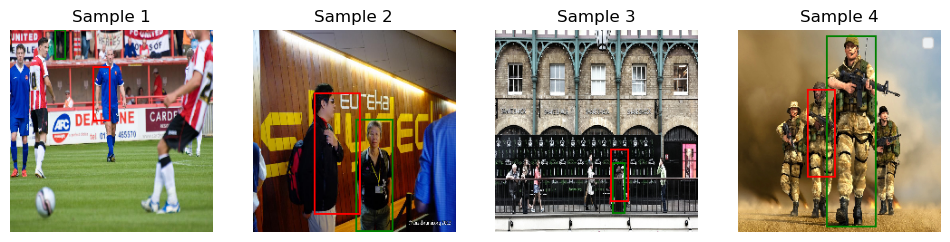

In [22]:
# Plot bounding boxes for a few samples
plot_bounding_boxes(X_test, y_test, predictions, num_samples=4)